In [2]:
import numpy as np
from numpy import linalg as LA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!git clone https://github.com/willowsierra/recvis22_a3

Cloning into 'recvis22_a3'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [4]:
!mv recvis22_a3/* .

In [ ]:
!mv drive/MyDrive/bird_dataset .

mv: cannot stat 'drive/MyDrive/bird_dataset': No such file or directory


In [5]:
import zipfile
!wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
#!unzip drive/MyDrive/bird_dataset.zip 
!unzip bird_dataset.zip

--2022-11-24 19:58:14--  https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘bird_dataset.zip’

bird_dataset.zip        [                <=> ] 183.48M  12.7MB/s    in 17s     

2022-11-24 19:58:32 (10.9 MB/s) - ‘bird_dataset.zip’ saved [192388716]

Archive:  bird_dataset.zip
   creating: bird_dataset/
   creating: bird_dataset/test_images/
   creating: bird_dataset/test_images/mistery_category/
  inflating: bird_dataset/test_images/mistery_category/002f61512a368e4c1434eedacf609957.jpg  
  inflating: bird_dataset/test_images/mistery_category/0247efd7b9d47d036bb4390202a13e69.jpg  
  inflating: bird_dataset/test_images/mistery_category/0267548c2aac82fe3d7e37ae98b00bd7.jpg  
  inflating: bird_dataset/test_images/mistery_category/030c7d

In [20]:
!rm -r experiment

### Loading data

In [23]:
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
from data import data_transforms
import PIL.Image as Image
import torchvision.transforms as transforms

torch.manual_seed(42)
use_cuda = torch.cuda.is_available()

if not os.path.isdir("experiment"):
    os.makedirs("experiment")

batch_size = 8
lr = 0.001
momentum = 0.9
epochs = 10
log_interval = 10

data_folder = "bird_dataset"

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_folder + '/train_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_folder + '/val_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)

### Visualizing the data

In [ ]:
from cv2 import imread

def get_counts(dataset_path,dataset_type):
  """Takes dataset's folder path and returns some basic details like species count, images count, height, width etc."""
  all_species_count = len(os.listdir(data_folder))
  all_species_names=[]
  species_image_count=[]
  all_heights=[]
  all_widths=[]
  for i in tqdm(os.listdir(data_folder)):
    all_species_names.append(i)
    species_folder_path = data_folder + "/" + i + "/"
    species_image_count.append(len(os.listdir(species_folder_path)))
    for j in os.listdir(species_folder_path):
      filename = species_folder_path + j
      image = imread(filename)
      print(image)
      all_heights.append(image.shape[0])
      all_widths.append(image.shape[1])
  print()
  print(f"Total no. of species in {dataset_type}= {all_species_count}")
  return all_species_names,species_image_count,all_heights,all_widths

In [ ]:
train_species_names,train_species_image_count,train_images_heights,train_images_widths = get_counts(dataset_path="bird_dataset",dataset_type="train")

  0%|          | 0/3 [00:00<?, ?it/s]

None


AttributeError: ignored

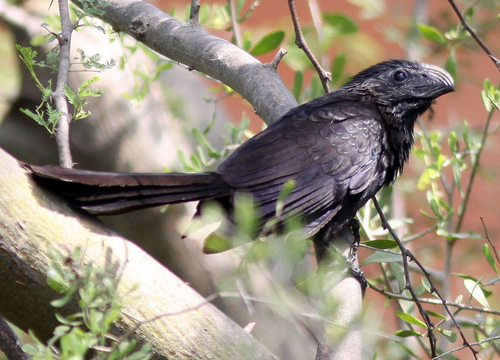

In [35]:
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(r"/content/bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0002_1670.jpg") 
  
# This method will show image in any image viewer 
im

In [ ]:
train_loader

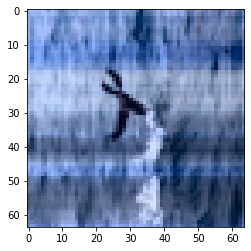

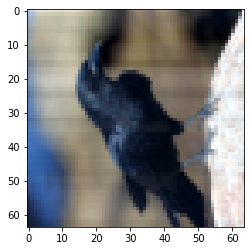

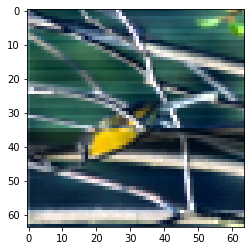

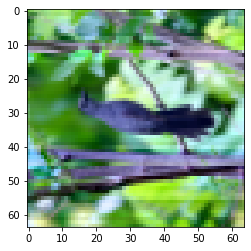

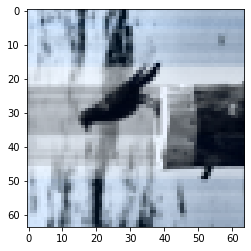

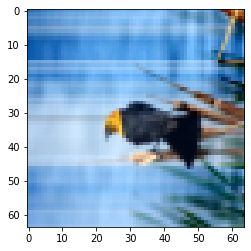

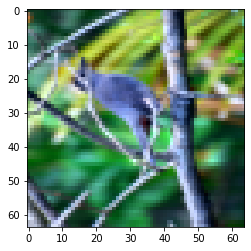

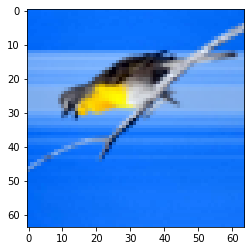

In [9]:
import matplotlib.pyplot as plt

for batch in train_loader:
    inputs, targets = batch
    for img in inputs:
        image  = img.cpu().numpy()
        # transpose image to fit plt input
        image = image.T
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        plt.imshow(scaled_data)
        plt.show()
    break

### Instanciating model

### Basic Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 20 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### Vision Transformer

In [11]:
!pip install -q transformers datasets pytorch-lightning

     |████████████████████████████████| 5.5 MB 28.3 MB/s 
     |████████████████████████████████| 451 kB 62.1 MB/s 
     |████████████████████████████████| 798 kB 57.2 MB/s 
     |████████████████████████████████| 182 kB 65.7 MB/s 
     |████████████████████████████████| 7.6 MB 57.4 MB/s 
     |████████████████████████████████| 115 kB 65.7 MB/s 
     |████████████████████████████████| 212 kB 63.7 MB/s 
     |████████████████████████████████| 127 kB 69.5 MB/s 
     |████████████████████████████████| 125 kB 68.9 MB/s 
     |████████████████████████████████| 529 kB 69.3 MB/s 
     |████████████████████████████████| 87 kB 7.6 MB/s 


In [14]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=20)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Training model

### Basic net

In [ ]:
# Neural network and optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
model = Net()
if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [19]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    model_file = 'experiment' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

model_file = 'experiment' + '/model.pth'
torch.save(model.state_dict(), model_file)

Train Epoch: 1 [0/1082 (0%)]	Loss: 2.931265
Train Epoch: 1 [80/1082 (7%)]	Loss: 2.949431
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.922380
Train Epoch: 1 [240/1082 (22%)]	Loss: 2.841699
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.796999
Train Epoch: 1 [400/1082 (37%)]	Loss: 2.781089
Train Epoch: 1 [480/1082 (44%)]	Loss: 2.744604
Train Epoch: 1 [560/1082 (51%)]	Loss: 2.678192
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.741749
Train Epoch: 1 [720/1082 (66%)]	Loss: 2.541391
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.511832
Train Epoch: 1 [880/1082 (81%)]	Loss: 2.470479
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.297439
Train Epoch: 1 [1040/1082 (96%)]	Loss: 2.396992

Validation set: Average loss: 0.2906, Accuracy: 79/103 (77%)
Saved model to experiment/model_1.pth. You can run `python evaluate.py --model experiment/model_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/1082 (0%)]	Loss: 2.245498
Train Epoch: 2 [80/1082 (7%)]	Loss: 2.187444
Train Epoch: 2 [160/1082 (15%)]	Loss: 2.135952
Tr

### Vision Transformer

In [21]:
# Neural network and optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
model = ViTLightningModule()
if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using GPU


In [24]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    model_file = 'experiment' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

model_file = 'experiment' + '/model.pth'
torch.save(model.state_dict(), model_file)

Train Epoch: 1 [0/1082 (0%)]	Loss: 2.202885
Train Epoch: 1 [80/1082 (7%)]	Loss: 2.188343
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.248995
Train Epoch: 1 [240/1082 (22%)]	Loss: 2.032147
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.960192
Train Epoch: 1 [400/1082 (37%)]	Loss: 1.855795
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.783399
Train Epoch: 1 [560/1082 (51%)]	Loss: 1.695870
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.728539
Train Epoch: 1 [720/1082 (66%)]	Loss: 1.502722
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.573681
Train Epoch: 1 [880/1082 (81%)]	Loss: 1.609113
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.429096
Train Epoch: 1 [1040/1082 (96%)]	Loss: 1.517318

Validation set: Average loss: 0.1768, Accuracy: 91/103 (88%)
Saved model to experiment/model_1.pth. You can run `python evaluate.py --model experiment/model_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/1082 (0%)]	Loss: 1.253237
Train Epoch: 2 [80/1082 (7%)]	Loss: 1.121140
Train Epoch: 2 [160/1082 (15%)]	Loss: 1.303953
Tr

### Evaluate

In [32]:
best_model = ViTLightningModule()
best_model.load_state_dict(torch.load("experiment/model_8.pth"))
best_model.eval()
best_model.to(torch.device('cuda'))

test_dir = data_folder + '/test_images/mistery_category'
outfile = 'experiment/kaggle.csv'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = best_model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')
        

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 517/517 [00:11<

Succesfully wrote experiment/kaggle.csv, you can upload this file to the kaggle competition website


# PARTIE LIGNE DE COMMANDE

### Model training with command line

In [ ]:
!python main.py --epochs 15

Using CPU
Train Epoch: 1 [0/1082 (0%)]	Loss: 3.004660
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.990727

Validation set: Average loss: 0.0580, Accuracy: 4/103 (4%)
Saved model to experiment/model_1.pth. You can run `python evaluate.py --model experiment/model_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/1082 (0%)]	Loss: 2.979465
Train Epoch: 2 [640/1082 (59%)]	Loss: 2.990573

Validation set: Average loss: 0.0571, Accuracy: 8/103 (8%)
Saved model to experiment/model_2.pth. You can run `python evaluate.py --model experiment/model_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/1082 (0%)]	Loss: 2.970789
Train Epoch: 3 [640/1082 (59%)]	Loss: 2.833346

Validation set: Average loss: 0.0533, Accuracy: 11/103 (11%)
Saved model to experiment/model_3.pth. You can run `python evaluate.py --model experiment/model_3.pth` to generate the Kaggle formatted csv file

Train Epoch: 4 [0/1082 (0%)]	Loss: 2.699180
Train Epoch: 4 [640/1082 (59%)]	Loss: 2.769624

Valid

### Final model evaluation

In [ ]:
!python evaluate.py --model experiment/model_10.pth

Using CPU
100% 517/517 [00:04<00:00, 117.46it/s]
Succesfully wrote experiment/kaggle.csv, you can upload this file to the kaggle competition website
